<div class="alert alert-block alert-warning">
Post Revision Notebook - Check out the handsonml git repo for detailed knowledge or just re-read the book!
</div>

# Setup
***

In [67]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the models and scores
import joblib
PROJECT_ROOT_DIR = "."
PROJECT_ID = "mnist"
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models", PROJECT_ID)
os.makedirs(MODELS_PATH, exist_ok=True)

# Save models, cross-val accuracy scores, cross-val predictions, and pipelines
def save_model(model, model_id):
    path = os.path.join(MODELS_PATH, model_id + "_model.pkl")
    print("Saving model", model_id)
    joblib.dump(model, path)

def save_scores(scores, model_id):
    path = os.path.join(MODELS_PATH, model_id + "_scores.pkl")
    print("Saving cross-val accuracy scores", model_id)
    joblib.dump(scores, path)
    
def save_cvpreds(cvpreds, pred_id):
    path = os.path.join(MODELS_PATH, pred_id + "_cvpreds.pkl")
    print("Saving cross-val predictions", pred_id)
    joblib.dump(cvpreds, path)

def save_pipe(pipe, pipe_id):
    path = os.path.join(MODELS_PATH, pipe_id + "_pipe.pkl")
    print("Saving pipeline", pipe_id)
    joblib.dump(pipe, path)

# Load saved models, cross-val predictions, and pipelines
def load_model(model_id):
    path = os.path.join(MODELS_PATH, model_id + "_model.pkl")
    return joblib.load(path)

def load_scores(model_id):
    path = os.path.join(MODELS_PATH, model_id + "_scores.pkl")
    return joblib.load(path)

def load_cvpreds(pred_id):
    path = os.path.join(MODELS_PATH, pred_id + "_cvpreds.pkl")
    return joblib.load(path)

def load_pip(pipe_id):
    path = os.path.join(MODELS_PATH, pipe_id + "_pipe.pkl")
    return joblib.load(path)

# Get the MNIST Dataset
***

In [28]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [29]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [30]:
X, y = mnist["data"], mnist["target"]

In [31]:
X.shape

(70000, 784)

In [32]:
pd.Series(y).value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
dtype: int64

- fairly evenly distributed

## Quick Exploration of Data

In [33]:
some_digit = X[0]

In [34]:
some_digit.shape

(784,)

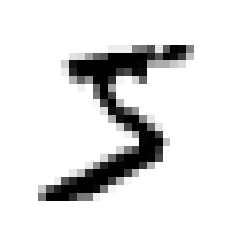

In [35]:
def plot_digit(digit):
    digit_image = digit.reshape(28, 28)
    plt.imshow(digit_image, cmap=mpl.cm.binary)
    plt.axis("off")
    plt.plot() # jupyter auto plots so this isn't necessary but it also doesn't hurt to add

plot_digit(some_digit)
plt.show()

In [36]:
y = y.astype(np.uint8)

- saves memory rather than saving as int64

In [37]:
X = X.astype(np.float64)

In [38]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## Creating Train and Test Sets

In [39]:
X_train, X_test = X[:60000, :], X[60000:, :]
y_train, y_test = y[:60000], y[60000:]

# Prepare the Data
***

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [41]:
preparation_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

In [42]:
X_train_prepared = preparation_pipeline.fit_transform(X_train)

# Model Selection
***

In [66]:
# models to test
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

Let's make a function that automates fitting all the models, saving them, calculating their cross-val predictions, saving those, and then returning the model with the highest accuracy.

In [83]:
def model_selection(estimators, model_ids, X=X_train_prepared, y=y_train):
    model_data = []
    for estimator, model_id in zip(estimators, model_ids):
        model = estimator.fit(X, y)
        save_model(model, model_id)
        
        scores = cross_val_score(model, X, y, cv=3, scoring="accuracy")
        save_scores(scores, model_id)
        
        model_data.append((model_id, scores.mean()))
    return model_data

In [86]:
model_ids = [
    "sgd_clf",
    "svm_clf",
    "forest_clf",
    "knn_clf",
]

In [87]:
def load_model_data(model_ids):
    model_data = []
    for model_id in model_ids:
        scores = load_scores(model_id)
        model_data.append((model_id, scores.mean()))
    return model_data

In [88]:
model_data = load_model_data(model_ids)

In [89]:
model_data

[('sgd_clf', 0.8970333333333333),
 ('svm_clf', 0.9601666666666667),
 ('forest_clf', 0.9644833333333334),
 ('knn_clf', 0.9403666666666667)]

- it seems that the random forest classifier is the most accurate
    - but svm, forest, and knn are all pretty close which means we can try fine-tuning all of them
        - it could also mean that it doesn't matter what the model is among the three

# Fine-Tuning
***